# This tutorial shows how to read in the deredden spectrum and how to use the QSOFIT fits output to retrieve continuum and line properties and to generate a QA plot.

In [1]:
import os,sys,time
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
#from astropy.modeling.blackbody import blackbody_lambda
from scipy import interpolate
from scipy import integrate
from astropy import constants as const
import pandas as pd
from qsofunc import *
from multiprocessing import Pool
warnings.filterwarnings("ignore")
from scipy.signal import medfilt
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib import rc

In [2]:
set_mpl_style(major=8.0,minor=4.0,lwidth=1.2)

# read QSOFit output

### read output by objID

In [3]:
obj_plate, obj_mjd, obj_fiber = 5808, 56325, 560             # input the objID
op_filename = 'op-%04d'%obj_plate+'-%5d'%obj_mjd+'-%04d'%obj_fiber

In [4]:
# read output data

op_data = fits.getdata('./download/'+op_filename+'.fits', 1)
# extension=1: main results

op_data_MC = fits.getdata('./download/'+op_filename+'.fits', 2)
# extension=2: MC results

op_data_spec = fits.getdata('./download/'+op_filename+'.fits', 3)
# extension=3: processed spectra

### the processed spectra
#### - bad pixel removed
#### - dereddened for Milky Way extinction
Dust map from Schlegel et al. (1998) and the Cardelli et al.(1989) extinction curve with $R_V=3.1$, then used the coefficient from Schlafly & Finkbeiner (2011) to convert SFD and Bayestar reddenings to magnitudes of $A_\nu$. 
#### - rest-frame shifted 
wavelength shifted by (1+Z_FIT) and flux multiplied by (1+Z_FIT)

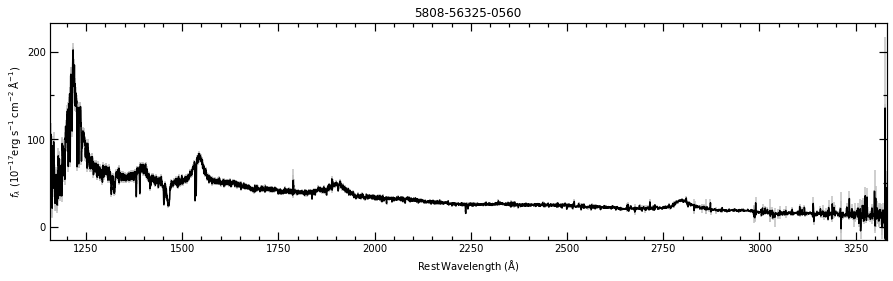

In [5]:
# processed spectrum
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.tick_params(which="both",bottom=True, top=True, left=True, right=True)
ax.errorbar(op_data_spec.wave_prereduced, op_data_spec.flux_prereduced, yerr=op_data_spec.err_prereduced, \
            color='k', ecolor='silver', label='data', zorder=1)
ax.xaxis.set_major_locator(MultipleLocator(250.))
ax.xaxis.set_minor_locator(MultipleLocator(50.))
ax.yaxis.set_major_locator(MultipleLocator(100.))
ax.yaxis.set_minor_locator(MultipleLocator(50.))
ax.set_title(op_filename[3:])
ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)')
ax.set_ylabel(r'$ f_{\lambda}$ ($\rm 10^{-17} {\rm erg\;s^{-1}\;cm^{-2}\;\AA^{-1}}$)')
ax.set_xlim(op_data_spec.wave_prereduced.min(), op_data_spec.wave_prereduced.max())
med_flux = medfilt(op_data_spec.flux_prereduced, kernel_size=5)
ax.set_ylim(-1.2*abs(med_flux.min()), 1.2*med_flux.max())
set_mpl_style(major=8.0,minor=4.0,lwidth=1.2)
plt.show()

# Read QSOFit parameters

### continuum fit results

The fitted continuum model:
$$f_{\rm conti} = f_{\rm PL} + f_{\rm poly} + f_{\rm FeII}$$
where,
$$f_{\rm PL}(\lambda) = a_0 (\lambda/\lambda_0)$$
$$f_{\rm poly}(\lambda) = \sum^{3}_{i=1} b_i (\lambda-\lambda_0)^i$$
$$f_{\rm FeII}(\lambda) = c_0 F_{\rm FeII} (\lambda, c_1, c_2)$$

In [6]:
# read continuum luminosity at 1350, 1700, 3000 and 5100 \AA
print('LOGL1350: %.3f'%op_data.L1350[0]+'+-%.3f'%op_data.L1350_err2[0] )
print('LOGL1700: %.3f'%op_data.L1700[0]+'+-%.3f'%op_data.L1700_err2[0] )
print('LOGL3000: %.3f'%op_data.L3000[0]+'+-%.3f'%op_data.L3000_err2[0] )

LOGL1350: 46.366+-0.001
LOGL1700: 46.351+-0.001
LOGL3000: 46.201+-0.002


In [7]:
# read continuum fitting parameters
conti_keyword = ['PL_norm', 'PL_slope', 'POLY_a', 'POLY_b', 'POLY_c',\
                 'Fe_uv_norm', 'Fe_uv_FWHM', 'Fe_uv_shift', 'Fe_op_norm', 'Fe_op_FWHM', 'Fe_op_shift']
conti_para = np.array([op_data[name][0] for name in conti_keyword])

# continuum fit model
conti_model = continuum_all(op_data_spec.wave_prereduced, conti_para)

# power law + poly continuum model
pl_model = conti_para[0]*(op_data_spec.wave_prereduced/3000.0)**conti_para[1]
poly_model = F_poly_conti(op_data_spec.wave_prereduced, conti_para[2:5])
pl_poly_model = pl_model + poly_model

# feII model
fe_model = Fe_flux_mgii(op_data_spec.wave_prereduced, conti_para[5:8]) \
         + Fe_flux_balmer(op_data_spec.wave_prereduced, conti_para[8:])

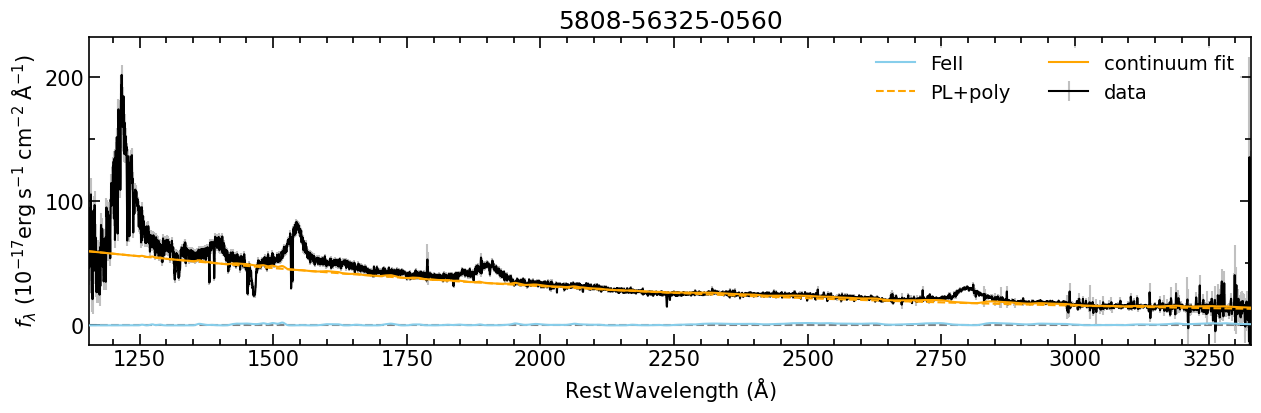

In [8]:
# plot continnum model
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.tick_params(which="both",bottom=True, top=True, left=True, right=True)
ax.errorbar(op_data_spec.wave_prereduced, op_data_spec.flux_prereduced, yerr=op_data_spec.err_prereduced, \
            color='k', ecolor='silver', label='data', zorder=1)
ax.plot(op_data_spec.wave_prereduced, fe_model, c='skyblue', zorder=3, label='FeII')
ax.plot(op_data_spec.wave_prereduced, pl_poly_model, c='orange', ls='--', label='PL+poly', zorder=4)
ax.plot(op_data_spec.wave_prereduced, conti_model, c='orange', label='continuum fit', zorder=5)
ax.axhline(0, ls='--', c='grey', zorder=0)
ax.xaxis.set_major_locator(MultipleLocator(250.))
ax.xaxis.set_minor_locator(MultipleLocator(50.))
ax.yaxis.set_major_locator(MultipleLocator(100.))
ax.yaxis.set_minor_locator(MultipleLocator(50.))
ax.set_title(op_filename[3:])
ax.legend(loc='upper right', ncol=2, edgecolor='None', facecolor='w', fontsize=14)
ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)')
ax.set_ylabel(r'$ f_{\lambda}$ ($\rm 10^{-17} {\rm erg\;s^{-1}\;cm^{-2}\;\AA^{-1}}$)')
ax.set_xlim(op_data_spec.wave_prereduced.min(), op_data_spec.wave_prereduced.max())
med_flux = medfilt(op_data_spec.flux_prereduced, kernel_size=5)
ax.set_ylim(-1.2*abs(med_flux.min()), 1.2*med_flux.max())
set_mpl_style(major=8.0,minor=4.0,lwidth=1.2)
plt.show()

### line fit results

In [9]:
op_linelist = np.array(['HALPHA', 'HALPHA_BR', 'NII6585', 'SII6718', \
                        'HBETA', 'HBETA_BR', 'HEII4687', 'HEII4687_BR', \
                        'OIII5007', 'OIII5007C', 'CAII3934', 'OII3728', 'NEV3426', \
                        'MGII', 'MGII_BR', 'CIII_ALL', 'CIII_BR', \
                        'SIIII1892', 'ALIII1857', 'NIII1750', \
                        'CIV', 'HEII1640', 'HEII1640_BR', \
                        'SIIV_OIV', 'OI1304', 'LYA', 'NV1240'])

To obtain the parameters of each line component use the following function
get_line_prop(linename, conti_para, op_data, op_data_MC)
output units:
- Peak wavelength
- Flux ($\rm 10^{-17} erg s^{-1} cm^{-2}$)
- LogL (erg s$^{-1}$)
- FWHM (km s$^{-1}$)
- EW (angstrom)

In [10]:
# fitted complex line lists
comp_lst = np.array([op_data[hdn][0] for hdn in op_data.names if ('complex_name' in hdn) and ('local' not in hdn)])
ncomp = len(comp_lst)

# fitted individual line lists
line_lst = np.array([hdn[:-6] for hdn in op_data.names if ('_scale' in hdn) and ('err' not in hdn)])

print('Complex lines:', comp_lst)

Complex lines: ['Lya' 'SiIV' 'CIV' 'CIII' 'MgII']


In [11]:
# example of CIV & MgII
# the first argword is selected from op_linelist
line_para1 = get_line_prop('CIV', conti_para, op_data, op_data_MC)
line_para2 = get_line_prop('MGII_BR', conti_para, op_data, op_data_MC)

CIV
Peak wavelength:  1545.69+-0.73
Flux:  1938.86+-264.14
LogL:  44.81+-0.06
FWHM:  6611.59+-188.93
EW:  43.89+-6.22

MGII_BR
Peak wavelength:  2801.01+-0.99
Flux:  798.59+-15.74
LogL:  44.42+-0.01
FWHM:  5568.64+-133.13
EW:  44.54+-0.86



In [12]:
# calculate the fitted gaussian line fit models
line_flux = np.zeros(len(op_data_spec.wave_prereduced))
for l in range(len(line_lst)):
    line_gauss = np.array([op_data[line_lst[l]+'_scale'], op_data[line_lst[l]+'_centerwave'], \
                           op_data[line_lst[l]+'_sigma']])
    line_flux += Manygauss(np.log(op_data_spec.wave_prereduced), line_gauss)
ind_abs = np.in1d(op_data_spec.wave_prereduced, op_data_spec.wave_line_abs)

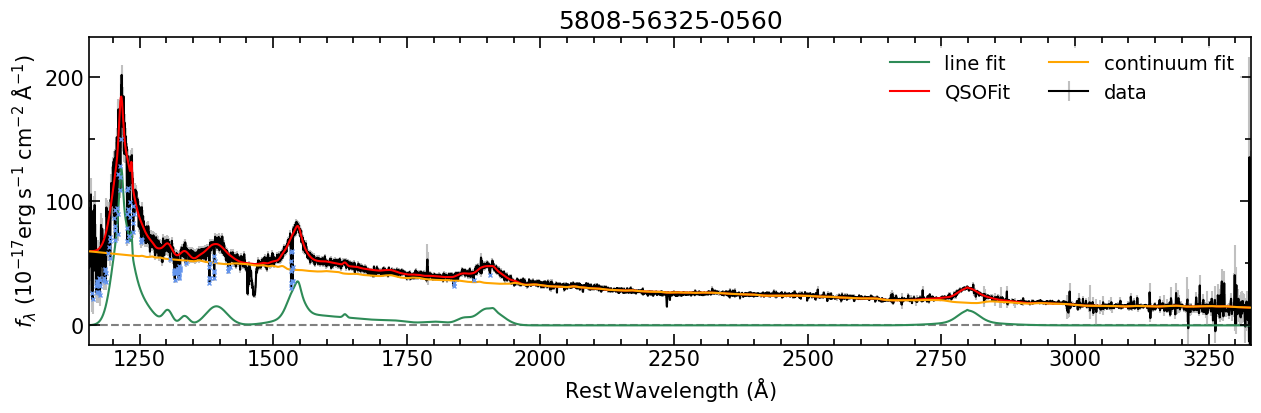

In [13]:
# plot QSOFit model
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.tick_params(which="both",bottom=True, top=True, left=True, right=True)
ax.errorbar(op_data_spec.wave_prereduced, op_data_spec.flux_prereduced, yerr=op_data_spec.err_prereduced, \
            color='k', ecolor='silver', label='data', zorder=1)
ax.plot(op_data_spec.wave_prereduced, line_flux, c='seagreen', label='line fit', zorder=2)
ax.plot(op_data_spec.wave_prereduced, conti_model+line_flux, c='red', label='QSOFit', zorder=2)
ax.plot(op_data_spec.wave_prereduced, conti_model, c='orange', label='continuum fit', zorder=5)
ax.plot(op_data_spec.wave_prereduced[ind_abs], op_data_spec.flux_prereduced[ind_abs], \
        ls='', marker='x', color='cornflowerblue', ms=3, zorder=7)
ax.legend(loc='upper right', ncol=2, edgecolor='None', facecolor='w', fontsize=14)
ax.axhline(0, ls='--', c='grey', zorder=0)
ax.xaxis.set_major_locator(MultipleLocator(250.))
ax.xaxis.set_minor_locator(MultipleLocator(50.))
ax.yaxis.set_major_locator(MultipleLocator(100.))
ax.yaxis.set_minor_locator(MultipleLocator(50.))
ax.set_title(op_filename[3:])
ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)')
ax.set_ylabel(r'$ f_{\lambda}$ ($\rm 10^{-17} {\rm erg\;s^{-1}\;cm^{-2}\;\AA^{-1}}$)')
ax.set_xlim(op_data_spec.wave_prereduced.min(), op_data_spec.wave_prereduced.max())
med_flux = medfilt(op_data_spec.flux_prereduced, kernel_size=5)
ax.set_ylim(-1.2*abs(med_flux.min()), 1.2*med_flux.max())
set_mpl_style(major=8.0,minor=4.0,lwidth=1.2)
plt.show()

# generate QA plots

In [14]:
# major lines
line_cen = np.array([6564.61,  6732.66, 4862.68, 5008.24, 4687.02, 4341.68, 3934.78, 3728.47, \
                     3426.84, 2798.75, 1908.72, 1816.97, 1750.26, 1718.55, 1549.06, 1640.42, 1402.06, 1396.76, 1335.30, \
                     1215.67])
line_name = np.array(['Ha+[NII]','[SII]6718,6732', 'Hb', '[OIII]', 'HeII4687', 'Hr', 'CaII3934', '[OII]3728', \
                     'NeV3426', 'MgII', 'CIII]', 'SiII1816', 'NIII]1750', 'NIV]1718', 'CIV', 'HeII1640', '', 'SiIV+OIV', \
                     'CII1335', 'Lya'])

In [15]:
# complex line list
complex_lines = np.array(['Ha', 'Hb', 'MgII', \
                          'CIII', 'CIV', 'SiIV', 'Lya', \
                          ])

# complex line range for plot
complex_line_range = np.array([[6400, 6800], [4640, 5100], [2700, 2900], \
                               [1700, 1970], [1500, 1700], [1290, 1450], [1150, 1290], \
                               ])

In [16]:
# adjust the plotting parameter for each lines
subline_xloc = np.array([70, 80, 100, 95, 100])
subline_yloc = np.array([50, 20, 20, 10, 10])
subline_yloc_range = np.array([[-50, 160], [-20, 42], [-19, 47], [-7, 32], [-6, 19]])

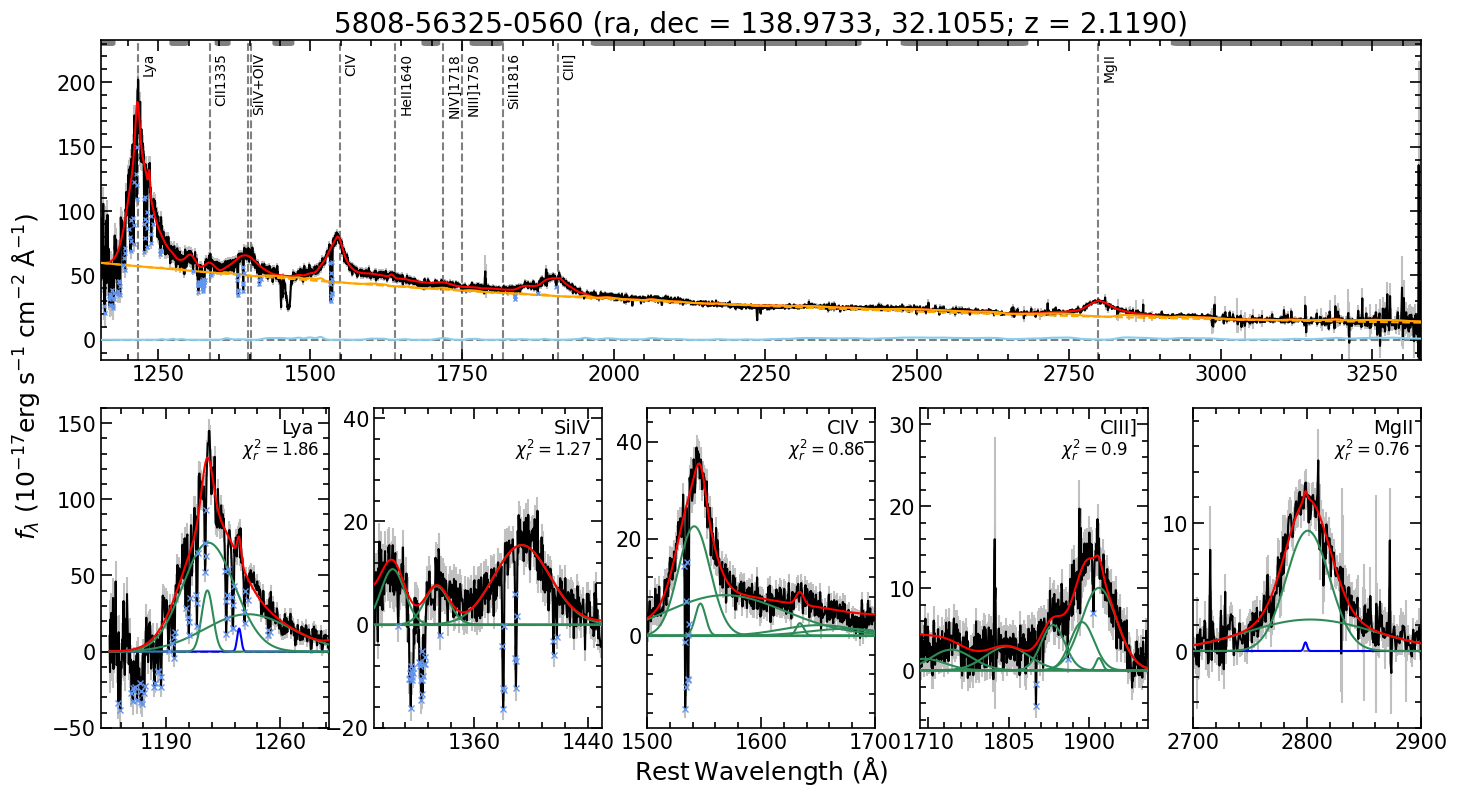

In [17]:
fig,axes = plt.subplots(1, 1, figsize=(15,8))
set_mpl_style(major=8.0,minor=4.0,lwidth=1.2)
ax1 = axes
ax1.set_position([0.07, 0.54, 0.88, 0.40])
ax1.set_title('%04d'%obj_plate+'-%5d'%obj_mjd+'-%04d'%obj_fiber+\
              ' (ra, dec = %.4f,'%op_data.RA+' %.4f'%op_data.DEC +'; z = %.4f'%op_data.Z_FIT+')', fontsize=20)

# plot the top panel -- overall view of the qsofit result
ax1.errorbar(op_data_spec.wave_prereduced, op_data_spec.flux_prereduced, yerr=op_data_spec.err_prereduced, \
            color='k', ecolor='silver', label='data', zorder=1)
ax1.plot(op_data_spec.wave_prereduced, fe_model, c='skyblue', zorder=3, label='FeII')
ax1.plot(op_data_spec.wave_prereduced, pl_poly_model, c='orange', ls='--', zorder=4)
ax1.plot(op_data_spec.wave_prereduced, conti_model+line_flux, c='red', label='QSOFit', zorder=2)
ax1.plot(op_data_spec.wave_prereduced, conti_model, c='orange', label='continuum', zorder=5)
ax1.plot(op_data_spec.wave_prereduced[ind_abs], op_data_spec.flux_prereduced[ind_abs], \
        ls='', marker='x', color='cornflowerblue', ms=3, zorder=7)

med_flux = medfilt(op_data_spec.flux_prereduced, kernel_size=5)
ax1.plot(op_data_spec.wave_conti, 1.2*med_flux.max()*np.ones(len(op_data_spec.wave_conti)), \
        color='grey', ls='', marker='s', zorder=1) # the continuum fitting windows
ax1.set_xlim(op_data_spec.wave_prereduced.min(), op_data_spec.wave_prereduced.max())
ax1.set_ylim(-1.2*abs(med_flux.min()), 1.2*med_flux.max())

# commonly seen quasar lines
for ll in range(len(line_cen)):
    if op_data_spec.wave_prereduced.min() < line_cen[ll] < op_data_spec.wave_prereduced.max():
        ax1.axvline(line_cen[ll], c='grey', ls='--', zorder=1)
        ax1.text(line_cen[ll]+7, med_flux.max()*1.15, line_name[ll], rotation=90, fontsize=10, va='top', zorder=5)

#ax1.legend(loc='upper right', ncol=2, edgecolor='None', facecolor='w', fontsize=14)
ax1.axhline(0, c='grey', ls='--', zorder=1)

ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_major_locator(MultipleLocator(250.))
ax1.xaxis.set_minor_locator(MultipleLocator(50.))
ax1.yaxis.set_major_locator(MultipleLocator(50.))
ax1.yaxis.set_minor_locator(MultipleLocator(10.))
ax1.tick_params(axis='x',which='both',direction='in')
ax1.tick_params(axis='y',which='both',direction='in')

# plot the bottom panel -- zoom-in view of complex lines
fig_dx = 0.03
fig_x = (0.88-(ncomp-1)*fig_dx)/ncomp
s = 0
for n in range(ncomp):
    ind_comp = np.where(complex_lines==comp_lst[n])[0]
    ind_line = np.where((op_data_spec.wave_prereduced>complex_line_range[ind_comp,0])\
                       &(op_data_spec.wave_prereduced<complex_line_range[ind_comp,1]))[0]
    ind_line2 = np.where((op_data_spec.wave_line_abs>complex_line_range[ind_comp,0])\
                       &(op_data_spec.wave_line_abs<complex_line_range[ind_comp,1]))[0]
    
    axn = fig.add_subplot(1,ncomp,n+1)
    axn.set_position([0.07+n*fig_x+n*fig_dx, 0.08, fig_x, 0.40])
    axn.errorbar(op_data_spec.wave_prereduced[ind_line], op_data_spec.flux_prereduced[ind_line]-conti_model[ind_line], \
                 yerr = op_data_spec.err_prereduced[ind_line], \
                 color='k', ecolor='silver', zorder=1)
    axn.errorbar(op_data_spec.wave_prereduced[ind_line], line_flux[ind_line], \
                color='red', zorder=4)
    axn.plot(op_data_spec.wave_line_abs[ind_line2], op_data_spec.flux_line_abs[ind_line2], \
            ls='', marker='x', color='cornflowerblue', ms=5, zorder=7)
    
    for ll in line_lst:
        if complex_line_range[ind_comp, 0]<np.exp(op_data[ll+'_centerwave'])<complex_line_range[ind_comp, 1]:
            line_gauss_para = np.array([op_data[ll+'_scale'][0], op_data[ll+'_centerwave'][0], op_data[ll+'_sigma'][0]])
            if 2*np.sqrt(2*np.log(2))*(np.exp(op_data[ll+'_sigma'][0])-1)*3.e5 < 1200.:
                line_color, line_order = 'b', 2
            else:
                line_color, line_order = 'seagreen', 3
            axn.plot(op_data_spec.wave_prereduced[ind_line], \
                     Manygauss(np.log(op_data_spec.wave_prereduced[ind_line]), line_gauss_para), \
                     color=line_color, zorder=line_order)

    axn.text(0.62, 0.85, r'$\chi ^2_r=$'+str(np.round(op_data[str(n+1)+'_line_red_chi2'][0], 2)),
            fontsize=12, transform=axn.transAxes)
    if comp_lst[n] == 'CIII':
        axn.text(0.79, 0.92, comp_lst[n]+']', fontsize=14, transform=axn.transAxes)
    else:
        axn.text(0.79, 0.92, comp_lst[n], fontsize=14, transform=axn.transAxes)
    axn.axhline(0, c='grey', ls='--', zorder=1)
    axn.set_xlim(complex_line_range[ind_comp,0], complex_line_range[ind_comp,1])
    axn.set_ylim(subline_yloc_range[s,0], subline_yloc_range[s,1])
    axn.xaxis.set_ticks_position('both')
    axn.yaxis.set_ticks_position('both')
    axn.xaxis.set_major_locator(MultipleLocator(subline_xloc[s]))
    axn.xaxis.set_minor_locator(MultipleLocator(subline_xloc[s]/5.))
    axn.yaxis.set_major_locator(MultipleLocator(subline_yloc[s]))
    axn.yaxis.set_minor_locator(MultipleLocator(subline_yloc[s]/5.))
    s += 1
    #axn.tick_params(axis='x',which='both',direction='in')
    #axn.tick_params(axis='y',which='both',direction='in')
    
ax1.text(0.5, -1.31, r'$\rm Rest \, Wavelength$ ($\rm \AA$)', fontsize=18, transform=ax1.transAxes,
        ha='center')
ax1.text(-0.05, -0.05, r'$ f_{\lambda}$ ($\rm 10^{-17} {\rm erg\;s^{-1}\;cm^{-2}\;\AA^{-1}}$)', fontsize=18,
        transform=ax1.transAxes, rotation=90, ha='center', rotation_mode='anchor')
plt.savefig('./op/'+'%04d'%obj_plate+'-%5d'%obj_mjd+'-%04d'%obj_fiber+'.pdf')